<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/glove_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend --upgrade

     |████████████████████████████████| 1.4MB 5.8MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank 

In [578]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [579]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [580]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


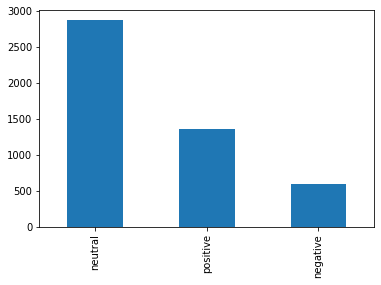

In [581]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [582]:
X= data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [583]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [584]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [585]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [600]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

positive    1090
negative    1090
neutral     1090
Name: sentiment, dtype: int64


# Prepare Data for model

In [587]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [588]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [589]:
max_len

71

In [601]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

# EMBEDDINGS

In [481]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [591]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [593]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [594]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [595]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [596]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [599]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3876, 3))

Epoch 1/20
52/52 [==============================] - 4s 33ms/step - loss: 1.1300 - precision: 0.4158 - recall: 0.1821 - accuracy: 0.3884 - val_loss: 1.0928 - val_precision: 0.3925 - val_recall: 0.1073 - val_accuracy: 0.3426
Epoch 2/20
52/52 [==============================] - 1s 18ms/step - loss: 0.9174 - precision: 0.5966 - recall: 0.3878 - accuracy: 0.5523 - val_loss: 1.0883 - val_precision: 0.4626 - val_recall: 0.2683 - val_accuracy: 0.4479
Epoch 3/20
52/52 [==============================] - 1s 17ms/step - loss: 0.8099 - precision: 0.6600 - recall: 0.5268 - accuracy: 0.6228 - val_loss: 0.6976 - val_precision: 0.7151 - val_recall: 0.6295 - val_accuracy: 0.6791
Epoch 4/20
52/52 [==============================] - 1s 17ms/step - loss: 0.7570 - precision: 0.6787 - recall: 0.5739 - accuracy: 0.6480 - val_loss: 0.7461 - val_precision: 0.7153 - val_recall: 0.6429 - val_accuracy: 0.6760
Epoch 5/20
52/52 [==============================] - 1s 17ms/step - loss: 0.7083 - precision: 0.7204 - recall

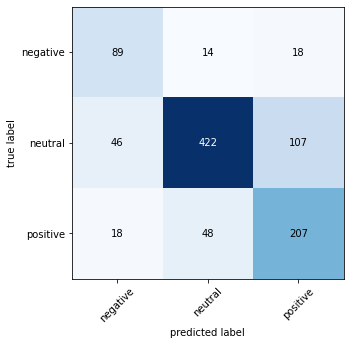

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.582     0.736       0.650        121
neutral         0.872     0.734       0.797        575
positive        0.623     0.758       0.684        273


In [604]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=False))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 'Precision', 'Recall', 'accuracy'])
# model.summary()

batch_size = 64
epochs = 20

model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq), 
          batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Representation of News in embeddings

In [89]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [90]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [91]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [119]:
news_df[news_df['content'].str.contains('-')]

,title,content,author,date


In [104]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    # for punct in '&':
    #     x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    for punct in "-":
        x = x.replace(punct, ' ')
    return x

In [105]:
news_df['content'] = news_df['content'].apply(lambda x: clean_text(x))

In [106]:
news_tokenizer = Tokenizer()
news_tokenizer.fit_on_texts(news_df['content'])

In [107]:
words_found = set()
words_not_found = set()
for word in news_tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)

In [108]:
len(words_found), len(words_not_found), len(news_tokenizer.word_index)

(10652, 2042, 12694)

In [97]:
len(words_found), len(words_not_found), len(news_tokenizer.word_index)

(10652, 2042, 12694)

## BiLSTM Model

### Preparing data to feed in model 

In [ ]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Make sequences of equal length 
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
print("After padding 1st sample became \n", X_train[0])

After padding 1st sample became 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1 520  48 659  16 445 274  12 521 160  10   1 660  84 275]


In [ ]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.inverse_transform([0, 1])

array(['negative', 'positive'], dtype=object)

### Model Building

In [ ]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.30))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='sum'))
model.add(Dropout(0.3))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 53, 100)           215000    
_________________________________________________________________
dropout_40 (Dropout)         (None, 53, 100)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 53, 200)           481600    
_________________________________________________________________
dropout_41 (Dropout)         (None, 53, 200)           0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                3216      
_________________________________________________________________
dropout_42 (Dropout)         (None, 16)              

In [ ]:
# plot_model(model)

In [ ]:
#Train Model

batch_size = 64
epochs = 8
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

Epoch 1/8
14/14 [==============================] - 4s 82ms/step - loss: 0.7942 - accuracy: 0.4679 - precision: 0.4147 - recall: 0.3037 - val_loss: 0.7199 - val_accuracy: 0.3470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
14/14 [==============================] - 0s 20ms/step - loss: 0.6948 - accuracy: 0.5349 - precision: 0.5352 - recall: 0.5267 - val_loss: 0.6724 - val_accuracy: 0.7032 - val_precision: 0.6970 - val_recall: 0.9650
Epoch 3/8
14/14 [==============================] - 0s 20ms/step - loss: 0.6388 - accuracy: 0.6271 - precision: 0.6008 - recall: 0.8103 - val_loss: 0.7538 - val_accuracy: 0.6484 - val_precision: 0.8173 - val_recall: 0.5944
Epoch 4/8
14/14 [==============================] - 0s 20ms/step - loss: 0.5226 - accuracy: 0.8000 - precision: 0.8157 - recall: 0.7688 - val_loss: 0.5615 - val_accuracy: 0.7580 - val_precision: 0.7848 - val_recall: 0.8671
Epoch 5/8
14/14 [==============================] - 0s 21ms/step - loss: 0.3283 - accuracy: 0.9197 - prec

In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Testing auc : {:.2f}".format(test_acc * 100))

Testing auc : 80.82


In [ ]:
preds = model.predict(X_test, batch_size=batch_size)

In [ ]:
roc_auc_score(y_test, preds)

0.8353882959146118

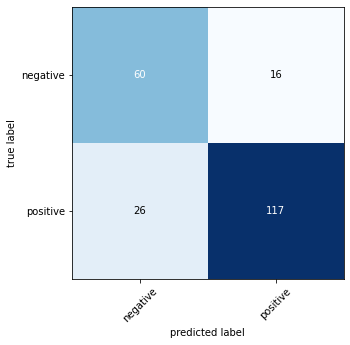

In [ ]:
c_mat = confusion_matrix(y_test, np.round(preds))
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

In [ ]:
# Precision, recall, f1 score and support
# Precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test, np.round(preds), average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.698     0.789       0.741         76
positive        0.880     0.818       0.848        143


# Prepare NEPSE DATA

In [605]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [606]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [607]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)

In [608]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)

In [609]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [610]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [611]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)
# news_df['pred_glove_300'] = np.argmax(news_sentiment, axis=1)

In [612]:
news_sentiment.shape

(6307, 3)

In [613]:
news_sentiment_df = pd.DataFrame(news_sentiment, columns=['negative', 'neutral', 'positive'])

In [614]:
final_df = pd.concat([news_df, news_sentiment_df], axis=1)

In [615]:
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [616]:
indices

,no_name,date,index,abs_change,pct_change,target
0,1590,2014-02-02,775.92,-5.54,-0.70,0
1,1589,2014-02-03,769.51,-6.41,-0.83,0
2,1588,2014-02-04,774.91,5.40,0.70,1
3,1587,2014-02-05,781.38,6.47,0.83,1
4,1586,2014-02-06,785.78,4.40,0.56,1
...,...,...,...,...,...,...
1233,351,2019-06-24,"1,260.10",5.75,0.46,1
1234,350,2019-06-25,"1,261.07",0.96,0.08,1
1235,349,2019-06-26,"1,258.29",-2.78,-0.22,0
1236,347,2019-06-30,"1,244.89",-12.27,-0.98,0


In [617]:
df = pd.merge(news_df, indices, left_on='date', right_on='date')

In [618]:
df= df[['date', 'content','pct_change', 'target']]

In [619]:
df['sentiment'] = np.argmax(news_sentiment, axis=1)

In [620]:
df

,date,content,pct_change,target,sentiment
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,-0.70,0,0
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,-0.70,0,1
2,2014-02-02,The government has stopped monitoring of shops...,-0.70,0,0
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,-0.70,0,1
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,-0.70,0,0
...,...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,-0.98,0,1
6303,2019-06-30,It will be first facility of its kind in the K...,-0.98,0,1
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...",-0.98,0,1
6305,2019-06-30,Domestic supply has helped keep prices stable ...,-0.98,0,2


In [621]:
news_sentiment_df = pd.DataFrame(news_sentiment, columns=['negative', 'neutral', 'positive'])

In [622]:
df = pd.concat([df, news_sentiment_df], axis=1)

In [623]:
df

,date,content,pct_change,target,sentiment,negative,neutral,positive
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,-0.70,0,0,0.876953,0.005885,0.117162
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,-0.70,0,1,0.016890,0.850553,0.132556
2,2014-02-02,The government has stopped monitoring of shops...,-0.70,0,0,0.870711,0.098536,0.030753
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,-0.70,0,1,0.007339,0.971797,0.020864
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,-0.70,0,0,0.886982,0.087527,0.025491
...,...,...,...,...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,-0.98,0,1,0.002860,0.870764,0.126375
6303,2019-06-30,It will be first facility of its kind in the K...,-0.98,0,1,0.003580,0.967892,0.028528
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...",-0.98,0,1,0.007303,0.952862,0.039835
6305,2019-06-30,Domestic supply has helped keep prices stable ...,-0.98,0,2,0.001844,0.021825,0.976331


In [627]:
df[(df['target'] == 0) & (df['sentiment'] == 0)]

,date,content,pct_change,target,sentiment,negative,neutral,positive
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,-0.70,0,0,0.876953,0.005885,0.117162
2,2014-02-02,The government has stopped monitoring of shops...,-0.70,0,0,0.870711,0.098536,0.030753
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,-0.70,0,0,0.886982,0.087527,0.025491
10,2014-02-03,The real estate sector posted a notable growth...,-0.83,0,0,0.769403,0.012295,0.218303
30,2014-02-09,The Civil Aviation Authority of Nepal has said...,-0.23,0,0,0.970346,0.011285,0.018368
...,...,...,...,...,...,...,...,...
6276,2019-06-12,Despite the government enacting the Foreign In...,-0.27,0,0,0.614274,0.118464,0.267263
6278,2019-06-13,Consumers said market prices shot up by over 2...,-0.23,0,0,0.752388,0.006510,0.241101
6279,2019-06-16,"With a downfall in the index, the average dail...",-0.89,0,0,0.938419,0.003567,0.058014
6281,2019-06-16,Frantic farmers in most of the districts in Pr...,-0.89,0,0,0.925244,0.052330,0.022427


In [652]:
a = df.groupby('date')['content'].apply(list).str.len()

In [661]:
a[a == 1].shape, a[a == 2].shape, a[a==3].shape, a[a == 4].shape, a

((18,), (38,), (88,), (197,))

In [663]:
a.describe()

count    1238.000000
mean        5.094507
std         1.400988
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: content, dtype: float64

In [550]:
df[(df['target'] == 1) & (df['sentiment'] == 2)]

,date,content,pct_change,target,sentiment,negative,neutral,positive
11,2014-02-04,The arrival of premium Chinese smartphones fro...,0.70,1,2,0.108351,0.367842,0.523807
13,2014-02-04,Ncell recorded an 11.3 percent rise in net sal...,0.70,1,2,0.438626,0.064685,0.496688
17,2014-02-05,"As the new academic session nears, the demand ...",0.83,1,2,0.124974,0.290778,0.584248
23,2014-02-06,The government will require Rs 510 million and...,0.56,1,2,0.010986,0.463042,0.525972
25,2014-02-06,The long-standing plan to bring in a strategic...,0.56,1,2,0.085489,0.407040,0.507470
...,...,...,...,...,...,...,...,...
6256,2019-05-30,Finance minister announces Rs99.85b for next f...,0.43,1,2,0.232550,0.364861,0.402589
6258,2019-05-30,The government will also impose Rs 1 as infras...,0.43,1,2,0.310768,0.118457,0.570775
6284,2019-06-17,Seven provincial governments have based their ...,0.21,1,2,0.166359,0.416567,0.417074
6289,2019-06-20,A joint venture of Kalika and Baniya Construct...,0.47,1,2,0.290363,0.307114,0.402523


In [551]:
df[(df['target'] == 0) & (df['sentiment'] == 1)]

,date,content,pct_change,target,sentiment,negative,neutral,positive
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,-0.70,0,1,0.027407,0.907738,0.064856
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,-0.70,0,1,0.018167,0.779137,0.202696
5,2014-02-03,"Talking about pricey threads, the domestic mar...",-0.83,0,1,0.027242,0.820643,0.152115
7,2014-02-03,Fifty-seven percent work has been completed on...,-0.83,0,1,0.045991,0.572259,0.381750
8,2014-02-03,The government is not in a position to assure ...,-0.83,0,1,0.131678,0.738900,0.129422
...,...,...,...,...,...,...,...,...
6299,2019-06-26,Capital restructuring and inducting a strategi...,-0.22,0,1,0.022127,0.638903,0.338970
6302,2019-06-30,Importers are being allowed to haul the goods ...,-0.98,0,1,0.120028,0.719366,0.160606
6303,2019-06-30,It will be first facility of its kind in the K...,-0.98,0,1,0.044705,0.594352,0.360942
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...",-0.98,0,1,0.072822,0.860510,0.066668


In [552]:
df.shape

(6307, 8)

In [667]:
negative_mean = df.groupby('date')['negative'].apply(np.mean).reset_index(drop=True)
neutral_mean = df.groupby('date')['neutral'].apply(np.mean).reset_index(drop=True)
positive_mean = df.groupby('date')['positive'].apply(np.mean).reset_index(drop=True)

In [669]:
indices['negative_mean'] = negative_mean.values
indices['neutral_mean'] = neutral_mean.values
indices['positive_mean'] = positive_mean.values


In [672]:
np.argmax(indices[['negative_mean', 'neutral_mean', 'positive_mean']].values, axis=1)

array([0, 1, 1, ..., 1, 1, 1])

In [674]:
indices['predicted'] = np.argmax(indices[['negative_mean', 'neutral_mean', 'positive_mean']].values, axis=1)

In [676]:
indices[['target','predicted']]

,target,predicted
0,0,0
1,0,1
2,1,1
3,1,1
4,1,1
...,...,...
1233,1,1
1234,1,1
1235,0,1
1236,0,1


In [677]:
indices[indices['target'] == indices['predicted']]

,no_name,date,index,abs_change,pct_change,target,negative_mean,neutral_mean,positive_mean,predicted
0,1590,2014-02-02,775.92,-5.54,-0.70,0,0.531775,0.402860,0.065365,0
2,1588,2014-02-04,774.91,5.40,0.70,1,0.064825,0.661742,0.273433,1
3,1587,2014-02-05,781.38,6.47,0.83,1,0.258081,0.598400,0.143519,1
4,1586,2014-02-06,785.78,4.40,0.56,1,0.328910,0.344083,0.327007,1
5,1585,2014-02-09,784,-1.78,-0.23,0,0.395239,0.275743,0.329018,0
...,...,...,...,...,...,...,...,...,...,...
1224,360,2019-06-11,"1,275.99",0.17,0.01,1,0.005278,0.948027,0.046696,1
1227,357,2019-06-16,"1,258.27",-11.36,-0.89,0,0.622285,0.342759,0.034957,0
1231,353,2019-06-20,"1,264.36",5.90,0.47,1,0.396212,0.511052,0.092736,1
1233,351,2019-06-24,"1,260.10",5.75,0.46,1,0.187580,0.585424,0.226996,1


In [681]:
indices[(indices['target'] == 1) & (indices['predicted']== 0)]

,no_name,date,index,abs_change,pct_change,target,negative_mean,neutral_mean,positive_mean,predicted
26,1564,2014-03-13,783.08,2.57,0.32,1,0.446126,0.307189,0.246685,0
36,1554,2014-03-31,792.19,9.04,1.15,1,0.406734,0.359177,0.234089,0
38,1552,2014-04-02,802.96,1.97,0.24,1,0.486365,0.357505,0.156130,0
62,1528,2014-05-12,852.68,3.05,0.36,1,0.381664,0.333571,0.284765,0
83,1507,2014-06-11,899.53,4.51,0.50,1,0.513907,0.311091,0.175002,0
...,...,...,...,...,...,...,...,...,...,...
1195,389,2019-04-28,"1,314.51",22.39,1.73,1,0.448870,0.377645,0.173485,0
1204,380,2019-05-12,"1,295.03",3.07,0.24,1,0.736722,0.056568,0.206710,0
1206,378,2019-05-14,"1,315.45",14.12,1.08,1,0.958674,0.026448,0.014877,0
1207,377,2019-05-15,"1,321.00",5.55,0.42,1,0.431267,0.347092,0.221641,0


In [678]:
accuracy_score(indices['target'], indices['predicted'])

0.31017770597738287

In [679]:
384/1238

0.31017770597738287

In [533]:
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [341]:
# np.argmax(indices[['negative_mean', 'neutral_mean', 'positive_mean']].values, axis=1)

array([1, 1, 1, ..., 1, 1, 1])

In [342]:
# indices['pred_glove_300'] = np.argmax(indices[['negative_mean', 'neutral_mean', 'positive_mean']].values, axis=1)

In [343]:
# accuracy_score(indices['target'], indices['pred_glove_300'])

0.36591276252019383

In [683]:
features = ['negative_mean','neutral_mean', 'positive_mean']

In [684]:
validation_df = indices[indices['date'] > '2018-12-31']
train_df = indices[indices['date'] <= '2018-12-31']

In [685]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_df[features], train_df['target'],
                                                stratify=train_df['target'],
                                                random_state=60, test_size=0.2 )


params = {
'num_leaves': 4,
'objective': 'binary',
'max_depth': 4,
'learning_rate': 0.05,
"boosting_type": "gbdt",
"bagging_seed": 11,
"metric": 'auc',
"verbosity": -1,
'random_state': 60
}
import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)

model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.630984	valid_1's auc: 0.514998
[20]	training's auc: 0.644539	valid_1's auc: 0.509454
[30]	training's auc: 0.650106	valid_1's auc: 0.521181
[40]	training's auc: 0.660994	valid_1's auc: 0.530993
[50]	training's auc: 0.666127	valid_1's auc: 0.51783
[60]	training's auc: 0.670902	valid_1's auc: 0.526127
[70]	training's auc: 0.677017	valid_1's auc: 0.524053
[80]	training's auc: 0.684007	valid_1's auc: 0.528799
Early stopping, best iteration is:
[39]	training's auc: 0.660396	valid_1's auc: 0.531153


In [686]:
accuracy_score(ytest, np.round(model.predict(Xtest)))

0.5357142857142857

In [687]:
accuracy_score(validation_df['target'],np.round(model.predict(validation_df[features])))

0.5289256198347108

In [539]:
# !pip install optuna

In [691]:
import optuna
from sklearn.metrics import roc_auc_score
from google.colab import output
# lgb_train = lgb.Dataset(Xt, Yt)
# lgb_eval = lgb.Dataset(Xv, Yv)

def objective(trial):    
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 512),
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 1, 16),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 80),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'max_bin': trial.suggest_int('max_bin', 4, 900),
            'early_stopping_rounds': 50,
            'random_state':60 
            }

    model = lgb.train(params, tr_data, valid_sets=[tr_data, va_data], verbose_eval=None, num_boost_round=5000)

    val_pred = model.predict(Xtest)
    score = roc_auc_score(ytest, val_pred)
    output.clear()
    # print(f"AUC = {score}")
    return score

In [699]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5000)

[I 2021-03-18 09:27:26,897] Trial 4999 finished with value: 0.5968089349820503 and parameters: {'num_leaves': 496, 'max_depth': 4, 'min_child_weight': 7, 'feature_fraction': 0.500061759809321, 'bagging_fraction': 0.7997742870946298, 'bagging_freq': 5, 'min_child_samples': 28, 'lambda_l1': 1.970886088921191e-08, 'lambda_l2': 0.05137571865891589, 'learning_rate': 0.9545619195523647, 'max_bin': 810}. Best is trial 4380 with value: 0.6849222177901875.


In [700]:
study.best_params

{'bagging_fraction': 0.8066193099148433,
 'bagging_freq': 5,
 'feature_fraction': 0.5322573492972873,
 'lambda_l1': 4.566263965400348e-08,
 'lambda_l2': 0.0018338038762390593,
 'learning_rate': 0.9840006396956522,
 'max_bin': 769,
 'max_depth': 4,
 'min_child_samples': 1,
 'min_child_weight': 6,
 'num_leaves': 511}

In [701]:

import lightgbm as lgb
tr_data = lgb.Dataset(Xtrain, label=ytrain)
va_data = lgb.Dataset(Xtest, label=ytest)
params = {
'objective': 'binary',
"boosting_type": "gbdt",
"metric": 'auc',
"verbosity": -1,
'random_state': 60,
'bagging_fraction': 0.8066193099148433,
 'bagging_freq': 5,
 'feature_fraction': 0.5322573492972873,
 'lambda_l1': 4.566263965400348e-08,
 'lambda_l2': 0.0018338038762390593,
 'learning_rate': 0.9840006396956522,
 'max_bin': 769,
 'max_depth': 4,
 'min_child_samples': 1,
 'min_child_weight': 6,
 'num_leaves': 511
}



model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,   
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,   
        feature_name=features,
        verbose_eval=10
    )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.689628	valid_1's auc: 0.554089
[20]	training's auc: 0.737073	valid_1's auc: 0.680574
[30]	training's auc: 0.787364	valid_1's auc: 0.662266
[40]	training's auc: 0.811388	valid_1's auc: 0.62844
[50]	training's auc: 0.839634	valid_1's auc: 0.583008
[60]	training's auc: 0.861697	valid_1's auc: 0.575509
Early stopping, best iteration is:
[18]	training's auc: 0.72939	valid_1's auc: 0.684922


In [702]:
accuracy_score(ytest, np.round(model.predict(Xtest)))

0.625

In [703]:
roc_auc_score(ytest, model.predict(Xtest))

0.6849222177901875

In [704]:
roc_auc_score(validation_df['target'], model.predict(validation_df[features]))

0.5740841990158557

In [705]:
accuracy_score(validation_df['target'], np.round(model.predict(validation_df[features])))

0.5537190082644629

In [ ]:
imdb_train, ds_info = tfds.load(name="imdb_reviews", split="train", 
                                with_info=True, as_supervised=True)
imdb_test = tfds.load(name="imdb_reviews", split="test", 
                      as_supervised=True)

In [ ]:
imdb_train = tfds.as_dataframe(imdb_train, ds_info)
imdb_test = tfds.as_dataframe(imdb_test, ds_info)

In [ ]:
imdb_train = imdb_train.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
imdb_test = imdb_test.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [ ]:
X_train = imdb_train['text']
y_train = imdb_train['label']
X_test = imdb_test['text']
y_test = imdb_test['label']

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test= tokenizer.texts_to_sequences(X_test)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])

In [ ]:
Tokenizer()

In [ ]:
X_train = pad_sequences(X_train, maxlen=150, padding='post', )
X_test = pad_sequences(X_test, maxlen = 150, padding='post')

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
n_classes = 1
def build_model_lstm(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
    mask_zero=True),
    tf.keras.layers.LSTM(rnn_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model



In [ ]:
vocab_size = len(word_index) +1
# The embedding dimension
embedding_dim = 64
# Number of RNN units
rnn_units = 64
# batch size
BATCH_SIZE=100
model = build_model_lstm(
    vocab_size = vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5669312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,702,401
Trainable params: 5,702,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])

model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1)


Epoch 1/10
250/250 [==============================] - 13s 42ms/step - loss: 0.5405 - accuracy: 0.7022 - precision: 0.7034 - recall: 0.7006
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 0.1774 - accuracy: 0.9366 - precision: 0.9344 - recall: 0.9400
Epoch 3/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0855 - accuracy: 0.9739 - precision: 0.9753 - recall: 0.9726
Epoch 4/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0499 - accuracy: 0.9856 - precision: 0.9844 - recall: 0.9867
Epoch 5/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0265 - accuracy: 0.9928 - precision: 0.9938 - recall: 0.9919
Epoch 6/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0303 - accuracy: 0.9909 - precision: 0.9922 - recall: 0.9897
Epoch 7/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0358 - accuracy: 0.9872 - precision: 0.9885 - recall: 0.9856
Epoch 8/10
250/250 [=======

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 3s 7ms/step - loss: 0.8269 - accuracy: 0.8362 - precision: 0.8356 - recall: 0.8370


[0.826852023601532, 0.8361600041389465, 0.8355693817138672, 0.8370400071144104]

In [ ]:
model.predict(X_test[0])

0.47636515299479165

In [ ]:
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [ ]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2493, 300)         26574900  
_________________________________________________________________
dropout (Dropout)            (None, 2493, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2493, 400)         801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2493, 400)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [ ]:
batch_size = 64
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/10
391/391 [==============================] - 35s 91ms/step - loss: 0.2858 - accuracy: 0.8836
Epoch 2/10
391/391 [==============================] - 35s 90ms/step - loss: 0.2051 - accuracy: 0.9219
Epoch 3/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1554 - accuracy: 0.9426
Epoch 4/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1183 - accuracy: 0.9592
Epoch 5/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0844 - accuracy: 0.9712
Epoch 6/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0571 - accuracy: 0.9808
Epoch 7/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0411 - accuracy: 0.9863
Epoch 8/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0280 - accuracy: 0.9912
Epoch 9/10
391/391 [==============================] - 35s 91ms/step - loss: 0.0179 - accuracy: 0.9943
Epoch 10/10
391/391 [==============================] - 35s 91ms/step - loss: 0.012

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 4s 13ms/step - loss: 0.6060 - accuracy: 0.8502


[0.6059731841087341, 0.8501999974250793]

In [ ]:
model.predict(X_test[0])

array([[3.94611120e-01, 6.05388880e-01],
       [7.62499988e-01, 2.37499967e-01],
       [9.99360025e-01, 6.39992417e-04],
       [2.54454720e-03, 9.97455418e-01],
       [2.42744815e-02, 9.75725532e-01],
       [5.18489957e-01, 4.81509984e-01],
       [1.93062499e-01, 8.06937516e-01],
       [8.01742554e-01, 1.98257491e-01],
       [6.38091326e-01, 3.61908704e-01],
       [4.71223384e-01, 5.28776646e-01],
       [8.80347371e-01, 1.19652607e-01],
       [3.91476555e-04, 9.99608576e-01],
       [9.98337388e-01, 1.66256400e-03],
       [3.48617882e-01, 6.51382089e-01],
       [5.72086036e-01, 4.27913964e-01],
       [9.84464467e-01, 1.55354915e-02],
       [1.09254186e-04, 9.99890685e-01],
       [1.99941069e-01, 8.00058901e-01],
       [8.08977187e-01, 1.91022769e-01],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [9.69207048e-01, 3.07929907e-02],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [6.921743